In [11]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import numpy as np

In [12]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder('../data/raw/', transform=transform)

In [13]:
# Function to split dataset into train, validation, and test sets
def split_dataset(dataset, test_size=0.2, val_size=0.2):
    # Get the class indices for all samples in the dataset
    targets = dataset.targets
    train_idx, test_idx = train_test_split(
        range(len(targets)), test_size=test_size, stratify=targets)

    # Split the train set further into train and validation sets
    train_idx, val_idx = train_test_split(
        train_idx, test_size=val_size / (1 - test_size), stratify=[targets[i] for i in train_idx])

    return train_idx, val_idx, test_idx

In [14]:
# Split the dataset
train_idx, val_idx, test_idx = split_dataset(dataset)

# Create subsets for train, validation, and test
train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
test_subset = Subset(dataset, test_idx)

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

# Print the sizes of the datasets
print(f"Train set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_subset)}")

Train set size: 936
Validation set size: 312
Test set size: 312


In [15]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)
        out = self.global_avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [16]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, criterion, and optimizer
model = CNN(len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [32]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
       BatchNorm2d-3         [-1, 64, 224, 224]             128
            Conv2d-4         [-1, 64, 224, 224]          36,928
              ReLU-5         [-1, 64, 224, 224]               0
       BatchNorm2d-6         [-1, 64, 224, 224]             128
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
              ReLU-9        [-1, 128, 112, 112]               0
      BatchNorm2d-10        [-1, 128, 112, 112]             256
           Conv2d-11        [-1, 128, 112, 112]         147,584
             ReLU-12        [-1, 128, 112, 112]               0
      BatchNorm2d-13        [-1, 128, 112, 112]             256
        MaxPool2d-14          [-1, 128,

In [17]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)

        model.eval()
        val_loss = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss.append(loss.item())
        val_loss = np.mean(val_loss)

        train_losses[e] = train_loss
        val_losses[e] = val_loss
        dt = datetime.now() - t0

        print(f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Validation_loss:{val_loss:.3f} Duration:{dt}")

    return train_losses, val_losses

In [18]:
# Train the model
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)

Epoch : 1/10 Train_loss:3.432 Validation_loss:7.299 Duration:0:46:39.255882
Epoch : 2/10 Train_loss:2.855 Validation_loss:5.757 Duration:0:31:19.542988
Epoch : 3/10 Train_loss:2.471 Validation_loss:3.744 Duration:0:28:53.133499
Epoch : 4/10 Train_loss:2.227 Validation_loss:2.902 Duration:0:29:17.966740
Epoch : 5/10 Train_loss:2.016 Validation_loss:3.736 Duration:0:28:30.819849
Epoch : 6/10 Train_loss:1.855 Validation_loss:2.513 Duration:0:32:48.258111
Epoch : 7/10 Train_loss:1.758 Validation_loss:2.330 Duration:0:29:32.060568
Epoch : 8/10 Train_loss:1.641 Validation_loss:1.788 Duration:0:29:24.339262
Epoch : 9/10 Train_loss:1.565 Validation_loss:2.462 Duration:0:28:06.249073
Epoch : 10/10 Train_loss:1.582 Validation_loss:2.363 Duration:0:27:01.189890


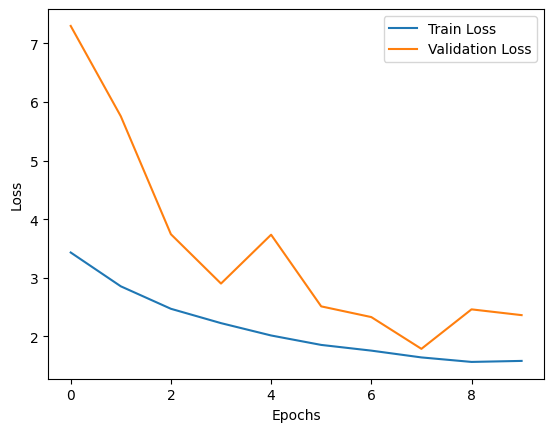

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            n_correct += (predictions == targets).sum().item()
            n_total += targets.shape[0]
    acc = n_correct / n_total
    return acc

train_acc = accuracy(train_loader)
val_acc = accuracy(val_loader)
test_acc = accuracy(test_loader)

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Train Accuracy: 42.95%
Validation Accuracy: 35.90%
Test Accuracy: 40.71%


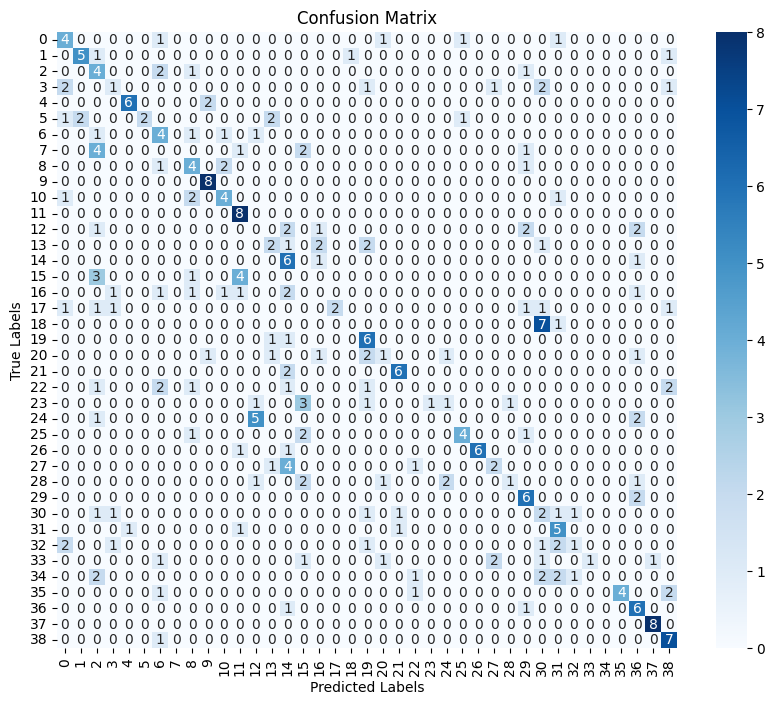

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Combine predictions and true labels for the entire dataset
true_labels, predicted_labels = [], []
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
torch.save(model.state_dict(), 'plant_disease_model.pt')

# Load the model
model.load_state_dict(torch.load('plant_disease_model.pt'))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=